0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


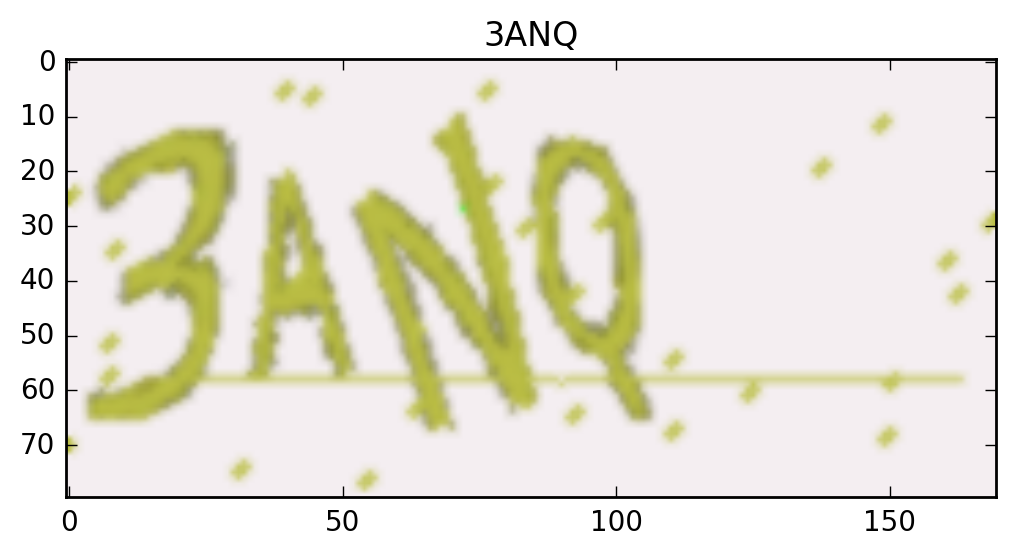

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
characters = string.digits + string.ascii_uppercase
print(characters)
width, height, n_len, n_class = 170, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [2]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

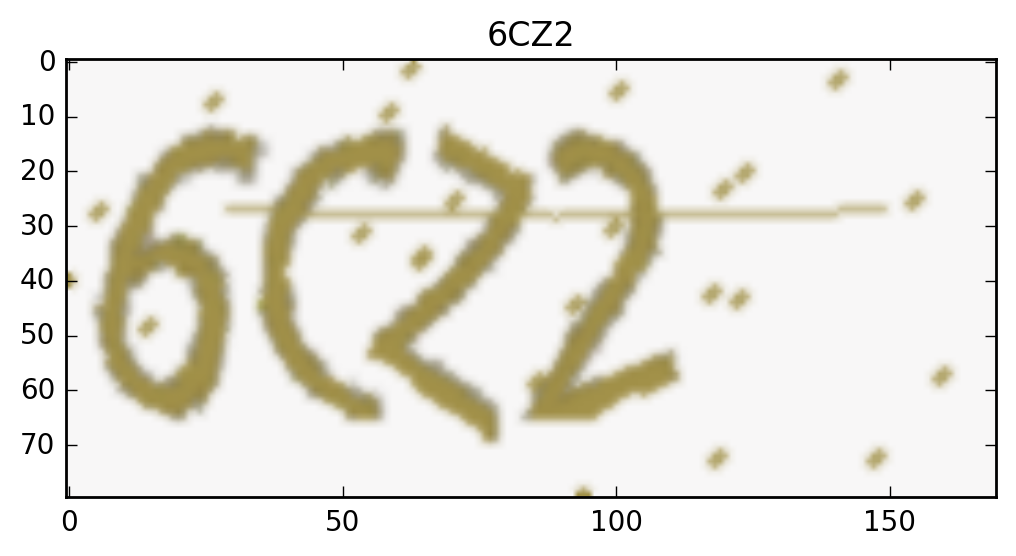

In [3]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [4]:
from keras.models import *
from keras.layers import *
input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    print i, x
    x = Convolution2D(32*2**i, 3, activation='relu')(x)
    print i, x
    x = Convolution2D(32*2**i, 3, activation='relu')(x)
    print i, x
    x = MaxPooling2D((2, 2))(x)
    print i, x
x = Flatten()(x)
print x
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
print x
model = Model(input=input_tensor, output=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.


0 Tensor("input_1:0", shape=(?, 80, 170, 3), dtype=float32)
0 Tensor("conv2d_1/Relu:0", shape=(?, 78, 168, 32), dtype=float32)
0 Tensor("conv2d_2/Relu:0", shape=(?, 76, 166, 32), dtype=float32)
0 Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 38, 83, 32), dtype=float32)
1 Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 38, 83, 32), dtype=float32)
1 Tensor("conv2d_3/Relu:0", shape=(?, 36, 81, 64), dtype=float32)
1 Tensor("conv2d_4/Relu:0", shape=(?, 34, 79, 64), dtype=float32)
1 Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 17, 39, 64), dtype=float32)
2 Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 17, 39, 64), dtype=float32)
2 Tensor("conv2d_5/Relu:0", shape=(?, 15, 37, 128), dtype=float32)
2 Tensor("conv2d_6/Relu:0", shape=(?, 13, 35, 128), dtype=float32)
2 Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 6, 17, 128), dtype=float32)
3 Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 6, 17, 128), dtype=float32)
3 Tensor("conv2d_7/Relu:0", shape=(?, 4, 15, 256), dtype=float32)
3 Tensor("conv2d_8

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


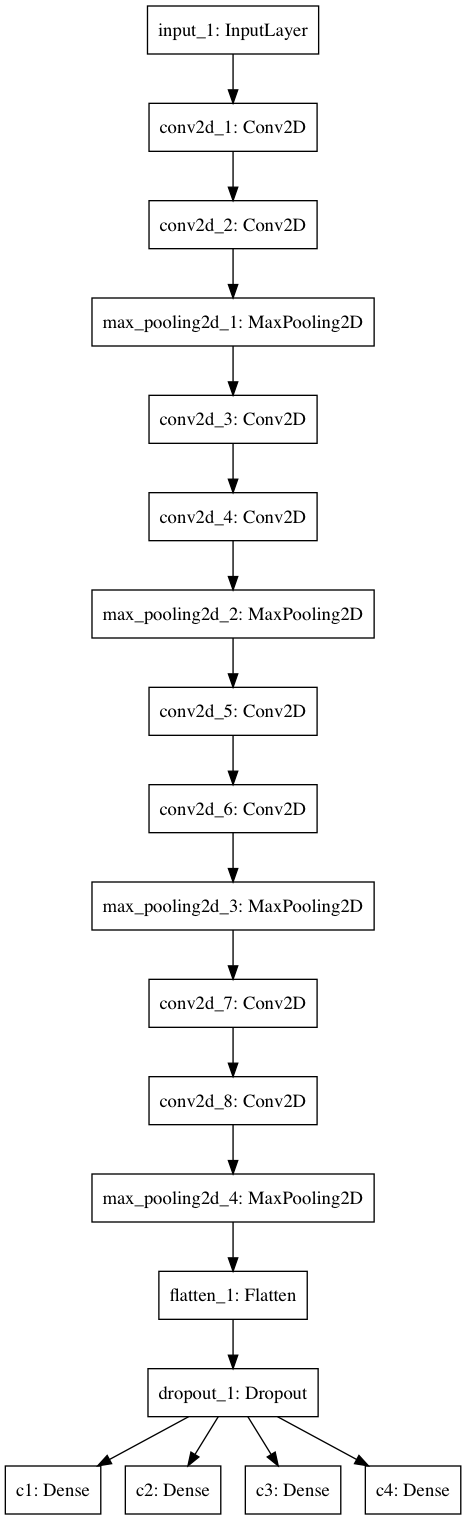

In [5]:
# from keras.utils.visualize_util import plot
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="model.png")#, show_shapes=True
Image('model.png')

In [ ]:
model.fit_generator(gen(), samples_per_epoch=5120, nb_epoch=50, 
                    nb_worker=4, pickle_safe=True, 
                    validation_data=gen(), nb_val_samples=1280)

In [ ]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')